# Random Time Series Validation

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import seaborn as sns
from tqdm import tqdm
from statsmodels.tsa.ar_model import AutoReg
from settings import path_data

In [2]:
ds_solar = xr.open_dataset(path_data / 'Solar_forcing_1st_mill.nc')
ds_volc = xr.open_dataset(path_data / 'Volc_Forc_AOD_1st_mill.nc')
ds_temp_r1 = xr.open_dataset(path_data / 'T2m_R1_ym_1stMill.nc')
ds_temp_r2 = xr.open_dataset(path_data / 'T2m_R2_ym_1stMill.nc')

temp_r1 = ds_temp_r1['T2m'].values
temp_r2 = ds_temp_r2['T2m'].values

mean_temp_r1 = np.mean(np.mean(temp_r1, axis=1), axis=1)
mean_temp_r2 = np.mean(np.mean(temp_r2, axis=1), axis=1)

Model:r1, lag: 1, pearson: (0.7123885386975661, 1.6405276612820596e-155)
Model:r2, lag: 1, pearson: (0.7109186307778665, 1.3601737611558996e-154)
Model:r1, lag: 2, pearson: (0.5262136306573519, 3.092727903663131e-72)
Model:r2, lag: 2, pearson: (0.5125485703472155, 5.133515113836178e-68)
Model:r1, lag: 3, pearson: (0.42842338309877553, 7.353647508939624e-46)
Model:r2, lag: 3, pearson: (0.4089241741357475, 1.4904419003261516e-41)
Model:r1, lag: 4, pearson: (0.3429589731677264, 5.931617759615519e-29)
Model:r2, lag: 4, pearson: (0.3174570814018226, 7.9327444544309165e-25)
Model:r1, lag: 5, pearson: (0.25481353533552104, 2.8577294721251243e-16)
Model:r2, lag: 5, pearson: (0.2615756461144367, 4.315006082409957e-17)
Model:r1, lag: 6, pearson: (0.18185363940576238, 7.081499150164357e-09)
Model:r2, lag: 6, pearson: (0.23063598673831853, 1.5793667527509014e-13)
Model:r1, lag: 7, pearson: (0.11823341805496534, 0.00018006001334507665)
Model:r2, lag: 7, pearson: (0.18344800918020154, 5.201034120383

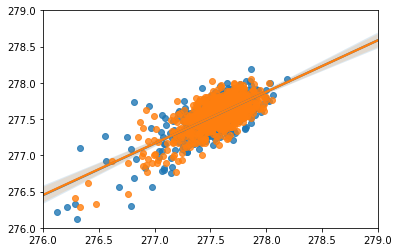

In [3]:
for s in range(1, 10):
    print(f'Model:r1, lag: {s}, pearson: {pearsonr(mean_temp_r1, np.roll(mean_temp_r1, s))}')
    print(f'Model:r2, lag: {s}, pearson: {pearsonr(mean_temp_r2, np.roll(mean_temp_r2, s))}')
    
plt.figure()
plt.xlim(276, 279)
plt.ylim(276, 279)
sns.regplot(x=mean_temp_r1, y=np.roll(mean_temp_r1, 1), truncate=False)
sns.regplot(x=mean_temp_r2, y=np.roll(mean_temp_r2, 1), truncate=False)
plt.show()

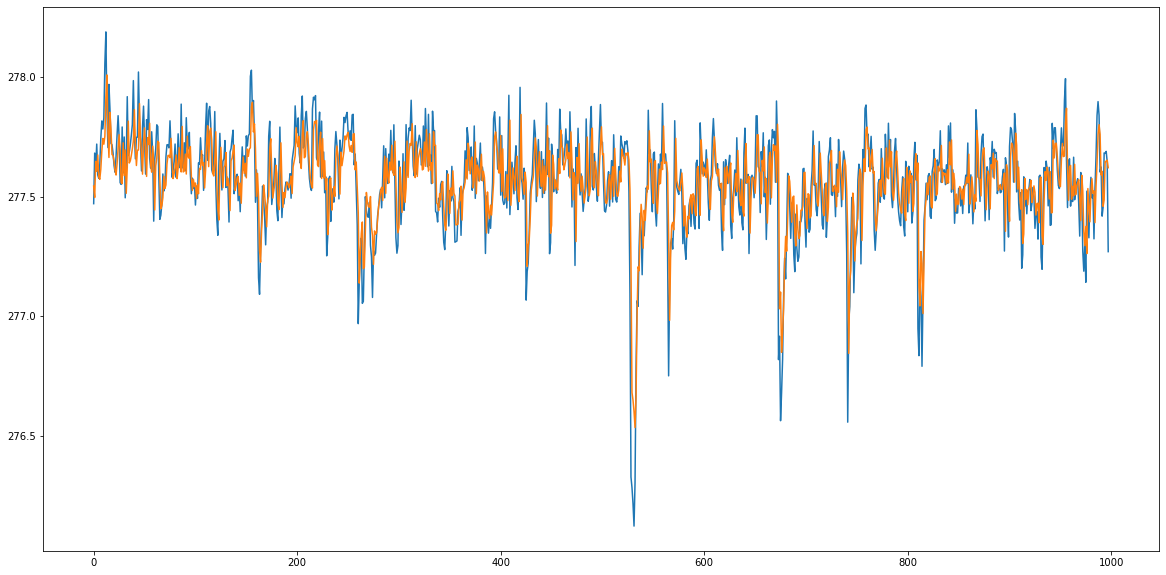

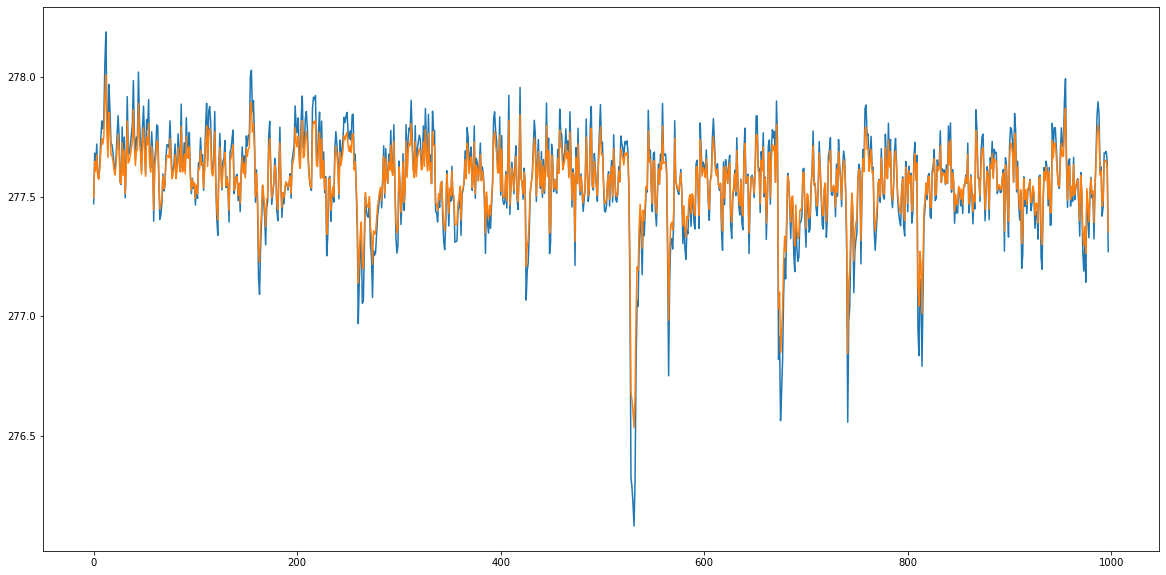

'plt.figure(figsize=(20, 10))\nplt.plot(ds_volc.AOD.values.flatten()[1:])\n#plt.plot((model.predict() - mean_temp_r1[1:]))\nvolcanic_binary_eruption = np.zeros((model.predict() - mean_temp_r1[1:]).shape)\nvolcanic_binary_eruption[np.abs(model.predict() - mean_temp_r1[1:]) > 0.3] = 0.5\nplt.plot(volcanic_binary_eruption)\nplt.show()'

In [4]:
model = AutoReg(mean_temp_r1, lags=1).fit()
beta_1, beta_2 = model.params

# comparison to actual data:
plt.figure(figsize=(20, 10))
plt.plot(mean_temp_r1[1:])
plt.plot(model.predict())
plt.show()

# check whether for loop works:
predicted_temp = []
for i in np.arange(1, 999):
    predicted_temp.append(beta_1 + beta_2*mean_temp_r1[i])
plt.figure(figsize=(20, 10))
plt.plot(mean_temp_r1[1:])
plt.plot(predicted_temp)
plt.show()

# volcanic eruption detection?
'''plt.figure(figsize=(20, 10))
plt.plot(ds_volc.AOD.values.flatten()[1:])
#plt.plot((model.predict() - mean_temp_r1[1:]))
volcanic_binary_eruption = np.zeros((model.predict() - mean_temp_r1[1:]).shape)
volcanic_binary_eruption[np.abs(model.predict() - mean_temp_r1[1:]) > 0.3] = 0.5
plt.plot(volcanic_binary_eruption)
plt.show()'''

In [5]:
# choose AR(1) to generate random time series. For initialization use linear regression of beta_1 and beta_2 params
beta_2 = []
beta_1 = []

reg = LinearRegression().fit(mean_temp_r1.reshape(-1,1), np.roll(mean_temp_r1, 1))
print('score: ', reg.score(mean_temp_r1.reshape(-1,1), np.roll(mean_temp_r1, 1)))
beta_2.append(reg.coef_)
beta_1.append(reg.intercept_)

reg = LinearRegression().fit(mean_temp_r2.reshape(-1,1), np.roll(mean_temp_r2, 1))
print('score: ', reg.score(mean_temp_r2.reshape(-1,1), np.roll(mean_temp_r2, 1)))
beta_2.append(reg.coef_)
beta_1.append(reg.intercept_)

beta_2 = np.mean(beta_2)
beta_1 = np.mean(beta_1)
print(beta_1, beta_2)

# find std in beta_1 and beta_2:
cov_matrix = np.sqrt(np.cov(np.array([mean_temp_r1, np.roll(mean_temp_r1, 1)])))
sigma_1 = cov_matrix[1, 1]
sigma_2 = cov_matrix[0, 1]
#sigma_epsilon = np.mean([np.std(temp_r1), np.std(temp_r2)])
mean_temp_first_year = np.mean([np.mean(temp_r1[0,:,:]), np.mean(temp_r2[0,:,:])])
std_temp_first_year = np.mean([np.std(temp_r1[0,:,:]), np.std(temp_r2[0,:,:])])

score:  0.507494216954395
score:  0.5054051904427181
80.03484 0.71165377


In [6]:
# create 1000 random time series according to: temp = beta_1 + beta_2*yr + epsilon

n_time_series = 1000

np.random.seed(42)
random_beta_1 = np.random.normal(loc=beta_1, scale=sigma_1**2, size=n_time_series)
random_beta_2 = np.random.normal(loc=beta_2, scale=sigma_2**4, size=n_time_series)
epsilon_init = np.random.normal(loc=0, scale=0.5, size=(n_time_series, 998))
#epsilon_pred = np.random.normal(loc=0, scale=0.1, size=(n_time_series, 998))

ts_list = np.zeros((998, n_time_series))
for ts in np.arange(n_time_series):
    ts_list[:, ts] = mean_temp_r1[:998] + epsilon_init[ts, :]
    ts_list[:, ts] = random_beta_1[ts] + random_beta_2[ts]*ts_list[:, ts]
print(ts_list.shape)

(998, 1000)


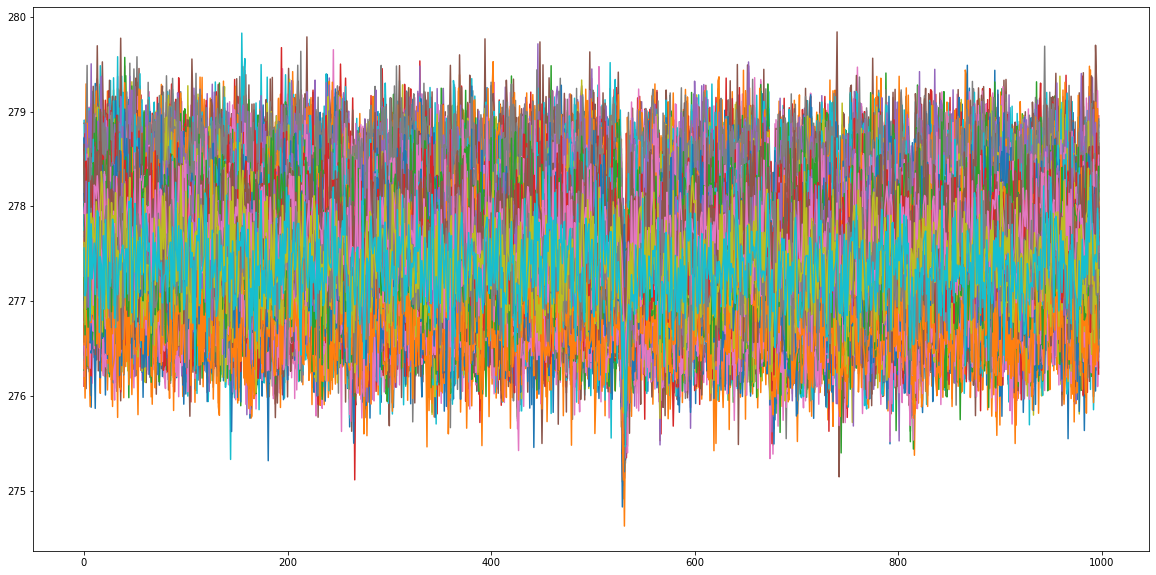

In [7]:
plt.figure(figsize=(20,10))
for i in np.arange(n_time_series):
    plt.plot(ts_list[:, i])
plt.show()

In [8]:
# check how the correlation looks like after smoothing:

def smooth_butter(data):
    # Butterworth filter settings
    cutoff = 0.125   # Hz
    order = 8
    [b, a] = signal.butter(order, cutoff)   # The second parameter is a normed value in [0;1] where 1 is the Nyquist frequency, i.e. half of the sampling rate. In the case of 25 FPS, this means that 1 = 12.5 Hz and hence 0.08 = 1 Hz

    # axis = 0 means that the filter is applied on each column
    data = signal.filtfilt(b, a, data, method='gust')

    return data

smoothed_sol = smooth_butter(ds_solar.TSI.values.flatten())
smoothed_vol =smooth_butter(ds_volc.AOD.values.flatten())

smoothed_random_series = ts_list.copy()
pearson_coeffs_sol = []
pearson_coeffs_vol = []
for i in np.arange(n_time_series):
    smoothed_random_series[:, i] = smooth_butter(smoothed_random_series[:, i])
    pearson_coeffs_sol.append(pearsonr(smoothed_random_series[:, i], smoothed_sol[1:])[0])
    pearson_coeffs_vol.append(pearsonr(smoothed_random_series[:, i], smoothed_vol[1:])[0])
#print(np.mean(pearson_coeffs_sol))
print(np.max(pearson_coeffs_sol), np.min(pearson_coeffs_vol))
#print(pearson_coeffs)


0.399853971630024 -0.5603667533218917
